### Week 8: SVM Classifier

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>


Citations: <br> 
   - Chapter 3: Python Machine Learning 3rd Edition by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019
   - https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
   - https://pythonmachinelearning.pro/using-neural-networks-for-regression-radial-basis-function-networks/
   - https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989

### Objectives: 
   - support vector machines for classification.
   - regularization.
   - breakout room exercise.

### Support Vector Machines (SVM):
 - to make classification predictions, SVM rely on few support vectors (suport vectors = observations in the data).
 - as a result, they take up very little memory (!).
 - their relyability on support vectors (observations near the margins) makes them very suitable for high-dimensional data (even when there are more features than observations).
 - finally, SVM is able to adapt to many types of data (linearly separable or not) due to the integration of kernel methods.
 
##### The not so good news:
 - the results can change significantly depending on the choice of the regularization parameter C (use cross-validation to choose it).
 - no direct probability interpretation (but easily added using the probability parameter in cross-validation).
 - and a final tought: be aware that the bigger the data the more expensive cross-validation is.

### Linear SVM
 - This model performs well on linearly separable classes. Linear logistic regression and linear SVM often yield very similar results. 
 - Logistic regression tries to maximize the conditional likelihood of the training data; so this means that it pays equal attention to outliers.
 - SVM avoids this problem, because it cares mostly about the points that are closest to the decission boundary (support vectors).

### Nonlinear SVM (kernel SVM)
- SVM can be easily **kernalized** to solve nonlinear classification problems. 
- The idea is to create nonlinear combinations of the original features, and then project them onto a higher-dimensional space via a mapping function.

### Step 1: Import packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os

# data visualization
import matplotlib.pyplot as plt
from IPython.display import Image

# data preprocessing
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# prediction models
from sklearn.svm import SVC

### Step 2: Define working directories

### Step 3: Define classes

### Step 4: Define functions

In [2]:
def wine_data():
    """Read the wine dataset from 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
    # param: None
    # return df and X,y np.arrays for training and test (cleaning included)
    """
    # read data
    df = pd.read_csv('https://archive.ics.uci.edu/'
                          'ml/machine-learning-databases/wine/wine.data',
                          header=None)

    df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
                  'alcalinity_of_ash', 'magnesium', 'total_pphenols',
                  'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
                  'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
                  'proline']

    print('Shape of df wine:', df.shape)

    # recode class labels (from 0 to 2)
    class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
    class_mapping
    df['class_label'] = df.class_label.map(class_mapping)


    # select only labels 0 and 1
    df = df[df.class_label !=2]

    # select only 2 features
    labels = ['class_label']
    features = ['alcohol', 'ash']
    df = df[labels+features]
    print('Class labels:', df['class_label'].unique())
    print('Features:', df.columns[1:])

    # create X and y arrays
    X = np.array(df.iloc[:, 1:])
    y = np.array(df.iloc[:, 0])
    
    # standardize features
    df['alcohol'] = preprocessing.scale(df['alcohol'])
    df['ash'] = preprocessing.scale(df['ash'])
    X = preprocessing.scale(X)
    
    return df, X, y

In [3]:
def plot_svc_decision_boundary(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=1, facecolors='none', edgecolor='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

---
### Step 5: Linear SVM example
---

#### Step 5.1 Read Iris data

In [4]:
s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases', 'iris','iris.data').replace('\\', '//')
print('URL:', s)

df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')
print('Shape if Iris:', df.shape)
df.head()

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Shape if Iris: (150, 5)


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# print type of flowers
df[4].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

#### Step 5.2 Data preprocessing

We will consider only two flower classes (Setosa and Versicolor) for practical reasons.

We will also restrict the analysis to only two feature variables, sepal length and petal length (easier to visualize the decission boundary in a 2D space).

In [6]:
# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot head of X
X[:5]

array([[5.1, 1.4],
       [4.9, 1.4],
       [4.7, 1.3],
       [4.6, 1.5],
       [5. , 1.4]])

Let's also standardize the variables for optimal performance.

In [7]:
sc = StandardScaler()
# estimate the sample mean and standard deviation for each feature in X_train
sc.fit(X)
# use the two parameters to standardize both X_train and X_test
X_std = sc.transform(X)

# we don't standardize y but let's rename it to be consistent with notation
y_std = y

# plot head of X_std
X_std[:5]

array([[-0.5810659 , -1.01435952],
       [-0.89430898, -1.01435952],
       [-1.20755205, -1.08374115],
       [-1.36417359, -0.94497788],
       [-0.73768744, -1.01435952]])

Finally, let's visualize the data to understand what we are trying to predict (classify)

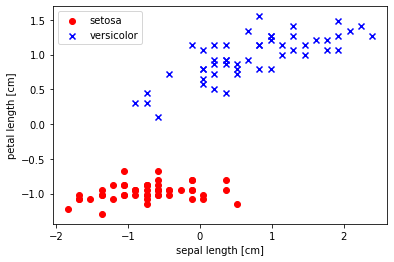

In [8]:
xfit = np.linspace(-2, 3.5)

# plot X data for setosa
plt.scatter(X_std[:50, 0], X_std[:50, 1],
            color='red', marker='o', label='setosa')

# plot X data for versicolor
plt.scatter(X_std[50:100, 0], X_std[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

The linear SVM classifier would attempt to draw a straight line separating the two sets of data to create a model for classification.

But there is a problem: there is more than one possible dividing line (decision boundary) that can perfectly discriminate between the two classes!

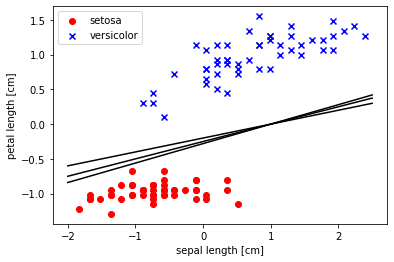

In [9]:
xfit = np.linspace(-2, 2.5)

# plot X data for setosa
plt.scatter(X_std[:50, 0], X_std[:50, 1],
            color='red', marker='o', label='setosa')

# plot X data for versicolor
plt.scatter(X_std[50:100, 0], X_std[50:100, 1],
            color='blue', marker='x', label='versicolor')

# plot decision boundaries (class separating lines)
#for m, b in [(0.2, -0.2)]:
#for m, b in [(0.2, -0.2), (0.25, -0.25)]:
for m, b in [(0.2, -0.2), (0.25, -0.25), (0.28, -0.28)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

So how do we choose the optimal line?

Linear SVM intuition: rather than simply drawing a zero-width line between the two classes, we can draw around each line a margin of some width, up to the nearest point (observation). 

The line that maximizes this margin is the one we will choose as the optimal model. Thus, SVM are an example of a maximum margin estimator.

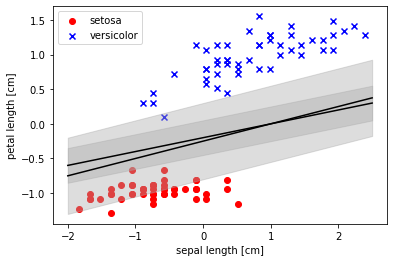

In [10]:
xfit = np.linspace(-2, 2.5)

# plot X data for setosa
plt.scatter(X_std[:50, 0], X_std[:50, 1],
            color='red', marker='o', label='setosa')

# plot X data for versicolor
plt.scatter(X_std[50:100, 0], X_std[50:100, 1],
            color='blue', marker='x', label='versicolor')

# plot decision boundaries with margins
for m, b, d in [(0.2, -0.2, 0.25), (0.25, -0.25, 0.55)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')


How does it compare with the perceptron model? Well, in the perceptron model, the objective function is to minimize the classification error. 

In SVM we want to choose the weights, **w**, to maximize the margin (this is the cost function):

$\mathbf{\frac{w^T(x\_pos - x\_neg)}{||w||}} = \frac{2}{\mathbf{||w||}}$, 

where $x\_pos$ are the points to the right of the decision boundary and $x\_neg$ are the points to the left.


#### Step 5.3 Prediction for linear SVM

In [11]:
svm_iris = SVC(kernel='linear', C=0.5) # C sets regularization
svm_iris.fit(X_std, y_std)

SVC(C=0.5, kernel='linear')

Let's visualize the optimal decission boundary and it's associated margin width.

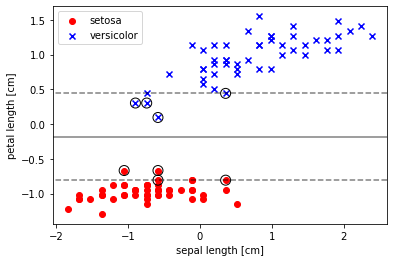

In [12]:
# plot X data for setosa
plt.scatter(X_std[:50, 0], X_std[:50, 1],
            color='red', marker='o', label='setosa')

# plot X data for versicolor
plt.scatter(X_std[50:100, 0], X_std[50:100, 1],
            color='blue', marker='x', label='versicolor')
# add labels
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plot decision boudary
plot_svc_decision_boundary(svm_iris)


The continous grey line is the dividing line that maximizes the margin between the two sets of points. 

Notice that a few of the training points just touch the margin (points highlighted with black circles). These points are the the important piece of the SVM solution, and are known as the support vectors. SVM relies mostly on these support vectors to make predictions!

In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier.

In [13]:
svm_iris.support_vectors_

array([[ 0.35866332, -0.80621461],
       [-0.5810659 , -0.80621461],
       [-1.05093052, -0.66745134],
       [-0.5810659 , -0.66745134],
       [-0.89430898,  0.30389157],
       [ 0.35866332,  0.44265484],
       [-0.73768744,  0.30389157],
       [-0.5810659 ,  0.09574666]])

A key to the SVM's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! 

The reason? these points do not contribute to the loss function used to fit the model, so their position and number do not matter as long as they do not cross the margin.

We can see this, for example, if we plot the model learned from X and the model learned from X where standardized petal length < 1cm (remove the top points):

In [14]:
# from X array keep only if standardized petal length (index 1 in X_std or index 2 in concatenated (y, X_std)) < 1
temp = pd.concat((pd.DataFrame(y),pd.DataFrame(X_std)),axis=1)
temp = temp[temp.iloc[:,2]<1]
X_std2 = np.array(temp.iloc[:,[1,2]])
y_std2 = np.array(temp.iloc[:,0])

In [15]:
svm_iris2 = SVC(kernel='linear', C=0.5) # C sets regularization
svm_iris2.fit(X_std2, y_std2)

SVC(C=0.5, kernel='linear')

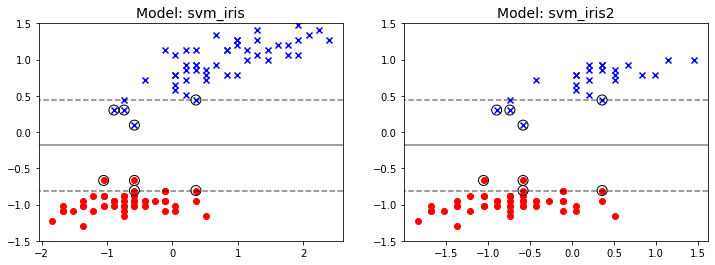

In [16]:
## create subplots
models = ['svm_iris', 'svm_iris2']

plt.figure(figsize=(12, 4)) 

for i in range(len(models)):
    # create sublots that are all on the same row
    ax = plt.subplot(1, len(models), i+1)
    
    # plot X data for setosa
    if i == 0:
        plt.scatter(X_std[:50, 0], X_std[:50, 1],
            color='red', marker='o', label='setosa')
    else:
        plt.scatter(X_std2[:50, 0], X_std2[:50, 1],
            color='red', marker='o', label='setosa')
        
    # plot X data for versicolor
    if i == 0:
        plt.scatter(X_std[50:, 0], X_std[50:, 1],
            color='blue', marker='x', label='versicolor')
    else:
        plt.scatter(X_std2[50:, 0], X_std2[50:, 1],
            color='blue', marker='x', label='setosa')
        
    # plot decision boundary
    if i == 0:
        plot_svc_decision_boundary(svm_iris)
    else:
        plot_svc_decision_boundary(svm_iris2)

    # set y limit
    plt.ylim(-1.5, 1.5)
    
    plt.title('Model: '+ str(models[i]), size=14)

In the left panel, we see the model and the support vectors for our initial svm model. In the right panel, we droped the points where standardized petal length < 1cm (remove the top points), but the model has not changed. 

The support vectors from the left panel are still the support vectors from the right panel! This insensitivity to distant points is one of the strengths of the SVM model!

---
### Step 6: Nonlinear (kernel) SVM example
---

The power of SVM becomes more obvious when we combine it with kernels. These kernels are very useful when dealing with nonlinearly separable data.

To give you an understanding of what a kernel is, think about the Linear Regression classifier. This classifier is used to fit linearly separable data, but if we project the data into a higher dimensional space (e.g., by adding polynomials and Gaussian basis functions), we can actually fit a nonlinear relationsip with this linear classifier.

#### Step 6.1 Read wine data

Now we will turn our attention to the wine dataset.

Let's focus only on two class labels (cultivar 0 and 1) and two features ('alcohol' and 'ash').

To save time and space , I defined the wine_data() function to import the data, keep only classes and features of interest, and standardizes the features.

In [17]:
df, X_std, y_std = wine_data()
df.head()

Shape of df wine: (178, 14)
Class labels: [0 1]
Features: Index(['alcohol', 'ash'], dtype='object')


,class_label,alcohol,ash
0,0,1.452455,0.302478
1,0,0.289066,-0.677197
2,0,0.243886,1.113242
3,0,1.610586,0.538951
4,0,0.334246,1.788880


#### Step 6.2 Data vizualization

to understand what we are trying to predict (classify)

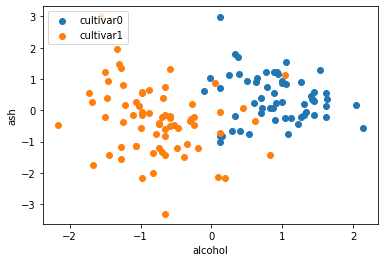

In [18]:
plt.scatter(df.loc[df.class_label==0, 'alcohol'], df.loc[df.class_label==0, 'ash'], label='cultivar0')
plt.scatter(df.loc[df.class_label==1, 'alcohol'], df.loc[df.class_label==1, 'ash'], label='cultivar1')
plt.xlabel('alcohol');
plt.ylabel('ash');
plt.legend(loc='upper left');

#### Step 6.3 Prediction for linear SVM

In [19]:
svm_wine = SVC(kernel='linear', C=1.0)
svm_wine.fit(X_std, y_std)

SVC(kernel='linear')

Let's visualize the optimal decission boundary and it's associated margin width.

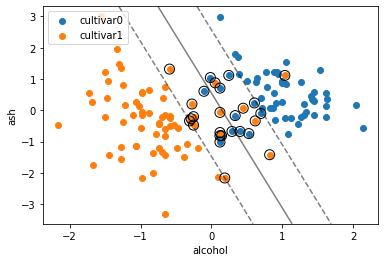

In [20]:
plt.scatter(df.loc[df.class_label==0, 'alcohol'], df.loc[df.class_label==0, 'ash'], label='cultivar0')
plt.scatter(df.loc[df.class_label==1, 'alcohol'], df.loc[df.class_label==1, 'ash'], label='cultivar1')
plt.xlabel('alcohol');
plt.ylabel('ash');
plt.legend(loc='upper left');

plot_svc_decision_boundary(svm_wine, plot_support=True);

It is clear that no linear discrimination will be able to separate this data. 

How we can go around it? 

Let's think about how we might project the data into a higher dimensional space (i.e., add more features) such that a linear separator would be sufficient. 

For example, one simple projection we could use would be to compute a radial basis function (RBF, also known as Gaussian kernel) **centered on the middle clump**.

In [21]:
def rbf(X, gamma):
    """ Code up Gaussian RBF
    # param X: np.array containing features of interest
    # param gamma: float, a free parameter, a cut-off for the Gaussian sphere (gamma=inverse of 2*sigma^2)
    # param s: float, standard deviations of the clusters.
    """
    
    # compute similarity, how close features are to each other
    return np.exp(-gamma* (np.subtract(X[:,0], X[:,1])**2))  # np.subtract(X[:,0], X[:,1])**2 is the squared Euclidean distance

rbf = rbf(X_std, 10) # hint: try changing the value of gamma and see what happens with the separating plane!
print(rbf.min())
print(rbf.max())


2.3100834081857688e-91
0.9977023411644994


We can visualize this extra data dimension using a three-dimensional plot

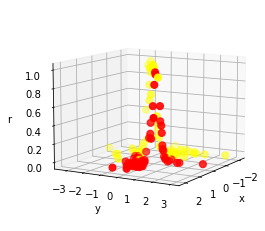

In [22]:
from mpl_toolkits import mplot3d
from ipywidgets import interact, fixed


ax = plt.subplot(projection='3d')
ax.scatter3D(X_std[:, 0], X_std[:, 1], rbf, c=y_std, s=50, cmap='autumn')
ax.view_init(elev=10, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

We can see that with this additional dimension, the data did not really become linearly separable. We can draw a clearly separating plane at, say, r=0.01.

After projection, we would like our data to look like in the figure below.

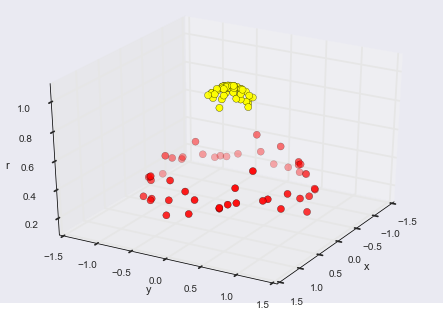

In [23]:
Image(filename='ideal_rbf.png', width=350)

So we can conclude that we did not carefully tune our projection.

We should have searched for the value of gamma that centers our RBF in the right location in order to see such a clea, linearly separable data.

But randomly choosing the best RBF funtion is time consumption, so we would like to find this automatically. The kernalized SVM in scikit-learn does this automatically for us by changing our linear kernel to an RBF, using the kernel model hyperparameter!

#### Step 6.4 Prediction for nonlinear (kernel) SVM

In [24]:
svm_wine = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_wine.fit(X_std, y_std)

SVC(gamma=0.1)

Let's look at the plots now

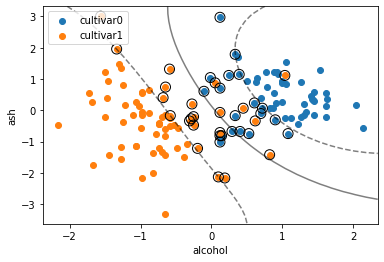

In [25]:
plt.scatter(df.loc[df.class_label==0, 'alcohol'], df.loc[df.class_label==0, 'ash'], label='cultivar0')
plt.scatter(df.loc[df.class_label==1, 'alcohol'], df.loc[df.class_label==1, 'ash'], label='cultivar1')
plt.xlabel('alcohol');
plt.ylabel('ash');
plt.legend(loc='upper left');

plot_svc_decision_boundary(svm_wine, plot_support=True);

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.


Question: What are the support vectors used to classify examples? (show them on the graph)

In [26]:
svm_wine.support_vectors_

array([[ 0.28906609, -0.67719651],
       [ 0.24388594,  1.11324246],
       [ 0.33424624,  1.78887981],
       [-0.01589994,  1.04567873],
       [-0.10626024,  0.60651445],
       [ 0.11964052,  2.97124517],
       [ 0.40201647, -0.67719651],
       [ 0.71827753,  0.06600457],
       [ 0.60532715,  0.23491391],
       [ 0.11964052,  0.70786005],
       [ 0.14223059, -0.81232398],
       [ 0.69568746, -0.10290477],
       [ 0.52626189, -0.74476025],
       [ 0.33424624, -0.1704685 ],
       [ 0.11964052, -0.81232398],
       [ 1.07971875, -0.74476025],
       [ 0.11964052, -1.01501519],
       [ 0.89899814, -0.30559597],
       [ 0.39072143,  1.14702433],
       [ 0.81993288, -1.42039759],
       [-0.64842207,  0.74164192],
       [ 0.18741075, -2.16359868],
       [ 0.44719662,  0.06600457],
       [ 1.0345386 ,  1.11324246],
       [ 0.61662219, -0.33937784],
       [ 0.05187029,  0.87676939],
       [ 0.09705044, -2.12981681],
       [-0.27568581,  0.20113204],
       [-0.25309574,

#### Step 6.4.1 The role of the gamma parameter

This parameter can be understood as the cut-off point for the Gaussian sphere. 

If we increase the value of gamma we increase the power of training examples (look at the RBF formula above to see the connection), which leads to a tighter and bumpier decision boundary. 

If we fit the training data very well (high gamma value) then we would likely end up with a high generalization error on unseen (test) data.

In [27]:
svm_wine = SVC(kernel='rbf', gamma=5, C=1.0) # change gamma from 0.1 to 5
svm_wine.fit(X_std, y_std)

SVC(gamma=5)

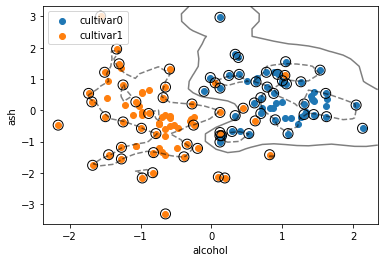

In [28]:
plt.scatter(df.loc[df.class_label==0, 'alcohol'], df.loc[df.class_label==0, 'ash'], label='cultivar0')
plt.scatter(df.loc[df.class_label==1, 'alcohol'], df.loc[df.class_label==1, 'ash'], label='cultivar1')
plt.xlabel('alcohol');
plt.ylabel('ash');
plt.legend(loc='upper left');

plot_svc_decision_boundary(svm_wine, plot_support=True);

#### Step 6.4.2 The role of the regularization (C) parameter

A familiar concept? Bias vs. Variance tradeoff

If a model suffers from overfitting, we also say that the model has high variance (the model is too complex, fits very well the training data).

If a model suffers from underfitting, we also say that the model has high bias (the model is not complex enough to capture the patern in the training data).

Decreasing the value of C, increases the bias and lowers the variance. So when we decrease the value of C we increase the width of the margin.

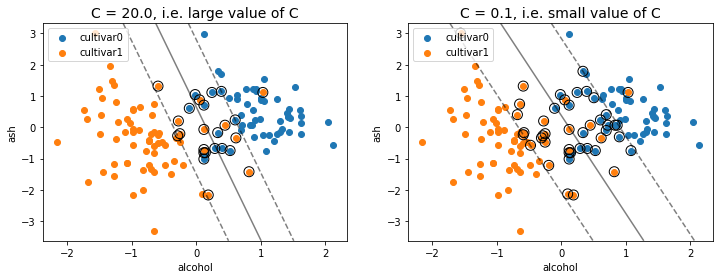

In [29]:
C = [20.0, 0.1]

plt.figure(figsize=(12, 4)) 

for i, c in enumerate(C):
    # create sublots that are all on the same row
    ax = plt.subplot(1, len(models), i+1)

    svm_wine = SVC(kernel='linear', C=c)
    svm_wine.fit(X_std, y_std)


    plt.scatter(df.loc[df.class_label==0, 'alcohol'], df.loc[df.class_label==0, 'ash'], label='cultivar0')
    plt.scatter(df.loc[df.class_label==1, 'alcohol'], df.loc[df.class_label==1, 'ash'], label='cultivar1')
    plt.xlabel('alcohol');
    plt.ylabel('ash');
    plt.legend(loc='upper left');

    plot_svc_decision_boundary(svm_wine, plot_support=True)

    if i == 0:
        plt.title('C = {0:.1f}'.format(c) + str(', i.e. large value of C'), size=14)
    else:
        plt.title('C = {0:.1f}'.format(c) + str(', i.e. small value of C'), size=14)

---
### Breakout room exercise 1

Using the diabetes dataset (download insuctions below), fit a SVM model to predict if a patient has diabetes or not. Your prediction is based on particular diagnosis measures that are included in the dataset. 

In particular, I would like you to focus on the following tasks:

   - plot X = ['Glucose', 'BMI'] data for outcome==1 and outcome==0 (see code example in this notebook). What can you conclude about the linear separability of your data?
   - fit a SVM model with a linear kernel. Report accuracy
   - fit a SVM model with an rbf kernel. Report accuracy
   - How sensitive are your results to different values of the gamma and C parameters?


Information about the daset and download instructions can be found here: https://www.kaggle.com/uciml/pima-indians-diabetes-database. 

Note also that the dataset is available in our GitHub repo under /data/week02/.

---
### Breakout room exercise 2

Using the wine dataset, execute the following tasks:

   - [1] split the data into train and test examples:
       - use train_test_split() method from scikit-learn's preprocessing module; set test_size parameter to 0.30;
       - report number of observations in the train and test data;
       
       ``Add answer here:`` 
       <br>
       
   - [2] fit a linear SVM on training data and predict on test data:
       - set C hyperparameter to 1.0;
       - report classification error for training and test data;
       
       ``Add answer here:``
       <br>
       
   - [3] fit a kernel SVM on training data and predict on test data:
       - set gamma and C hyperparameters to 0.20 and 10.0, respectively;
       - report classification error for training and test data;
       
       ``Add answer here:``
       <br>
       
   - [4] fit a kernel SVM on training data and predict on test data:
       - set gamma and C hyperparameters to 0.20 and 1.0, respectively;
       - report classification error for training and test data;
       
       ``Add answer here:``
       <br>